# Imports

In [1]:
# local imports
from scripts.data import generate_random_simulation, generate_features, SimulationData, save_result, load_result
from scripts.nn import create_autoencoder_model, train_encoder, train_encoder_with_constraints
from scripts.loss import recovery_loss, fixed_points_loss, subsequent_distances_loss, angle_differences_loss
from scripts.visualization import plot_loss_evolution, plot_multiloss_evolution, plot_embedding,plot_embedding_on_simulation, plot_embedding_pca

# pytorch
import torch
from torch.optim import Adam

# data manipulation
import numpy as np
from os.path import join, exists
from os import mkdir
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from itertools import chain

# visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Setup

In [2]:
N_STEPS = 200
N_SIMULATIONS = 200
MIN_X, MAX_X = [-10, 10]
MIN_Y, MAX_Y = [-10, 10]
N_ANCHORS = 5

In [3]:
DATA_PATH = 'data/'
simulations_file_name = join(DATA_PATH, 'generated_simulations.pt')
anchors_file_name = join(DATA_PATH, 'anchors_pos.pt')

#### generate data

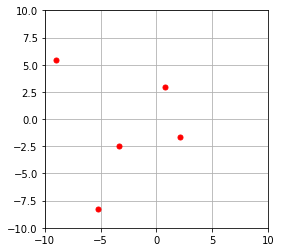

In [4]:
anchors_pos = torch.stack((
    MIN_X + (MAX_X - MIN_X) * torch.rand(N_ANCHORS),
    MIN_Y + (MAX_Y - MIN_Y) * torch.rand(N_ANCHORS)
), 1)

plt.figure(figsize=(4,4))
plt.plot(*anchors_pos.T, '.r', markersize=10)
plt.xlim([MIN_X, MAX_X])
plt.ylim([MIN_Y, MAX_Y])
plt.grid(True);

In [22]:
simulations = torch.stack([
    generate_random_simulation(MIN_X, MAX_X, MIN_Y, MAX_Y, N_STEPS)
for i in range(N_SIMULATIONS)])

#### save data

In [27]:
torch.save(simulations, simulations_file_name)
torch.save(anchors_pos, anchors_file_name)

#### load data 

In [4]:
simulations = torch.load(simulations_file_name)
anchors_pos = torch.load(anchors_file_name)

---

In [5]:
data = SimulationData(simulations, anchors_pos)

---

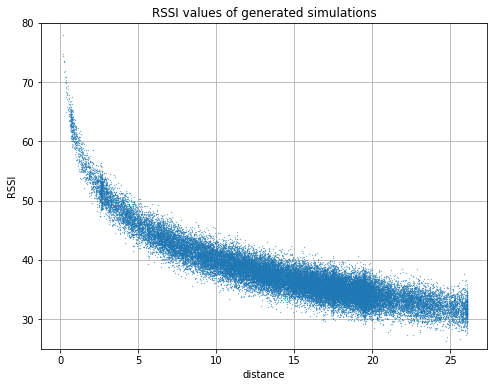

In [6]:
plt.figure(figsize=(8,6))
plt.grid()
plt.xlabel('distance')
plt.ylabel('RSSI')
plt.ylim([25, 80])
plt.title('RSSI values of generated simulations')
plt.plot(data.distances[:,:,0].flatten(), data.features[:,:,0].flatten(), '.', markersize=0.5)

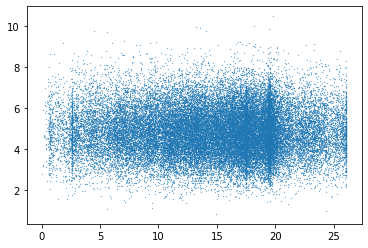

In [7]:
plt.plot(data.distances[:,:,0].flatten(), data.features[:,:,5].flatten(), '.', markersize=0.5)

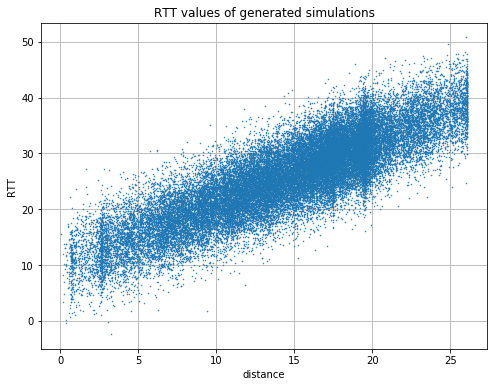

In [8]:
plt.figure(figsize=(8,6))
plt.grid()
plt.xlabel('distance')
plt.ylabel('RTT')
plt.title('RTT values of generated simulations')
plt.plot(data.distances[:,:,0].flatten(), data.features[:,:,10].flatten(), '.', markersize=1)

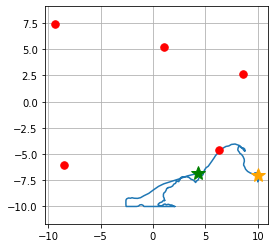

In [14]:
plt.figure(figsize=(4,4))
data.plot_simulation(data[0][1])

In [18]:
BATCH_SIZE = 1
N_EPOCHS = 500
train_loader, test_loader = data.get_random_loaders(0.8, BATCH_SIZE)

In [21]:
input_dim = 3 * N_ANCHORS

# Autoencoder

### Testing different embedding dimensions

Autoencoder with one hidden layer of 12 units

In [26]:
bot_dims = [2,3,4,5,6]
hid_dim = 12
n_dims = len(bot_dims)

Train autoencoder with bottleneck sizes of $[2,3,4,5,6]$

In [23]:
%%time

results = {}
for bot_dim in bot_dims:
    model = create_autoencoder_model(input_dim, hid_dim, bot_dim)
    
    train_loss, test_loss = train_encoder(model, train_loader, test_loader, N_EPOCHS)
    
    results[bot_dim] = {
        'model': model,
        'train_loss': train_loss,
        'test_loss': test_loss
    }

CPU times: user 9min 42s, sys: 8.52 s, total: 9min 50s
Wall time: 9min 52s


In [25]:
# Save results
for bot_dim in bot_dims:
    results_name = f'autoencoder_{bot_dim}D_embedding'
    save_result(results[bot_dim], results_name)

In [27]:
# Load results
results = {}
for bot_dim in bot_dims:
    results_name = f'autoencoder_{bot_dim}D_embedding'
    results[bot_dim] = load_result(results_name, create_autoencoder_model(input_dim, hid_dim, bot_dim))

---

Train and test error for each embedding dimension

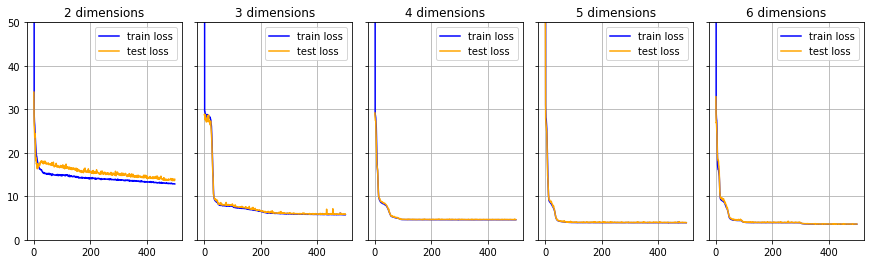

In [31]:
fig, ax = plt.subplots(nrows=(n_dims - 1) // 5 + 1, ncols=5, sharex=True, sharey=True, figsize=(15, 4))
plt.grid()
plt.subplots_adjust(wspace=0.1)

for i in range(n_dims):
    bot_dim = bot_dims[i]
    
    ax[i % 5].grid(True)
    ax[i % 5].plot(results[bot_dim]['train_loss'], c='blue')
    ax[i % 5].plot(results[bot_dim]['test_loss'], c='orange')
    ax[i % 5].legend(['train loss', 'test loss'])
    ax[i % 5].set_title(f'{bot_dim} dimensions')
    
plt.ylim(0, 50);

It looks like the 2 dimension model didn't converge yet.

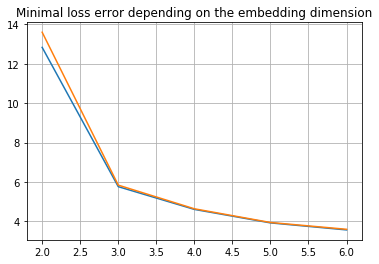

In [32]:
min_losses = {bot_dim: [min(results[bot_dim]['train_loss']), min(results[bot_dim]['test_loss'])] for bot_dim in bot_dims}

plt.title('Minimal loss error depending on the embedding dimension')
plt.grid(True)
plt.plot(bot_dims, [min_losses[bot_dim][0] for bot_dim in bot_dims])
plt.plot(bot_dims, [min_losses[bot_dim][1] for bot_dim in bot_dims]);

### 2-dimension embedding

Train an autoencoder with an embedding dimension of 2 for a longer time

In [21]:
%%time

model_2D = create_autoencoder_model(input_dim, h_dim, bot_dim=2)

train_losses_2D, test_losses_2D = train_encoder(model_2D, train_loader, test_loader, 20 * N_EPOCHS)
result_2D = {
    'model': model_2D,
    'train_loss': train_losses_2D,
    'test_loss': test_losses_2D
}

CPU times: user 22min 34s, sys: 12.2 s, total: 22min 46s
Wall time: 22min 42s


In [22]:
# Save result
result_name = 'autoencoder_2D_embedding_long'
save_result(result_2D, result_name)

In [16]:
# Load result
result_name = 'autoencoder_2D_embedding_long'
result_2D = load_result(result_name, create_autoencoder_model(2))

---

Train and test loss of 2D embedding for longer time

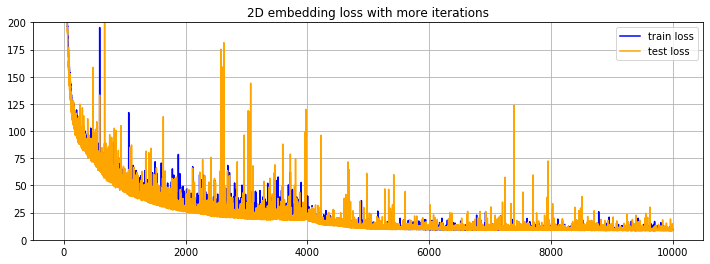

In [17]:
plt.figure(figsize=(12,4))
plt.title('2D embedding loss with more iterations')
plot_loss_evolution(result_2D['train_loss'], result_2D['test_loss'])

2D embedding plots

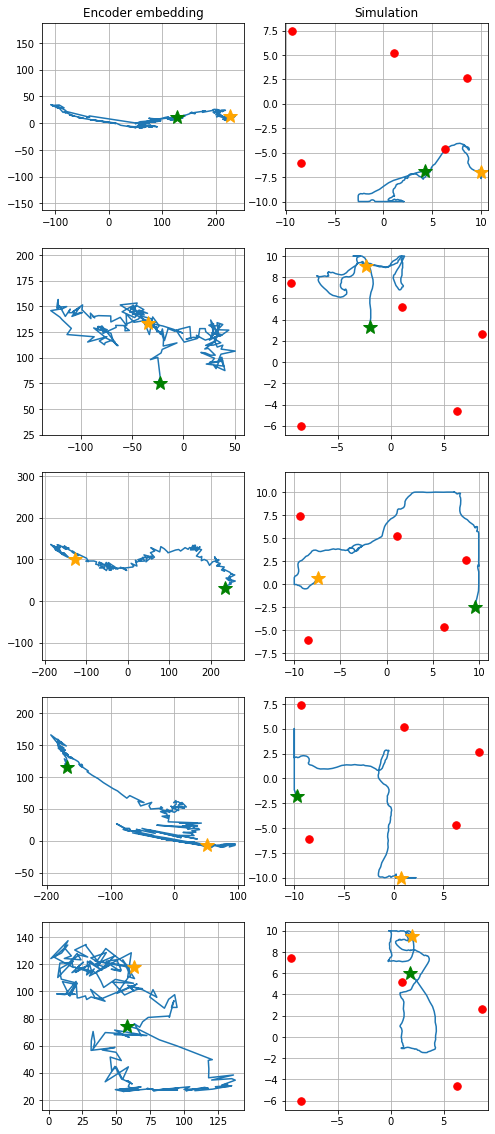

In [53]:
encoder, _ = result_2D['model']
plot_embedding(encoder, data, range(5))

#### Distance magnitude comparison

Compare if the distances magnitudes are proportional

In [27]:
encoded_data = encoder(data[:][0])
distance_matrix_input = pdist(data[0][0].view(1 * N_STEPS, 3 * N_ANCHORS))
distance_matrix_encoded = pdist(encoded_data[0].view(1 * N_STEPS, 2).detach())

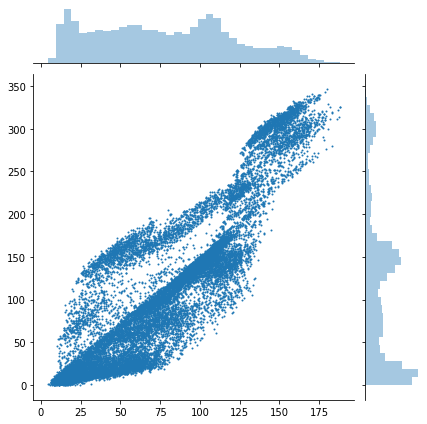

In [28]:
sns.jointplot(distance_matrix_input, distance_matrix_encoded, s=1)

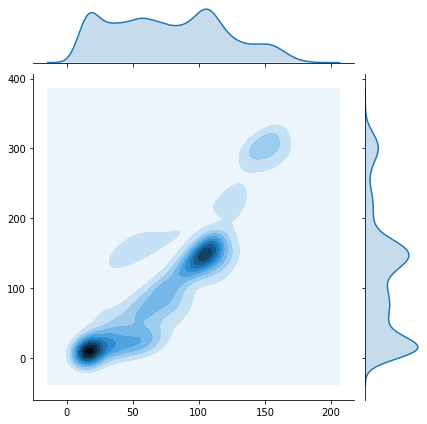

In [29]:
sns.jointplot(distance_matrix_input, distance_matrix_encoded, kind='kde')

### PCA

Try pca 2D embedding and compare with autoencoder

In [30]:
pca = PCA(n_components=2)
pca_2D_embedding = pca.fit_transform(data[:][0].view(N_SIMULATIONS * N_STEPS, 3 * N_ANCHORS))

In [31]:
def plot_embedding_pca(encoder, data, pca, indices):
    if isinstance(indices, int):
        indices = [indices]
    encoded = encoder(data[indices][0]).detach()
    pca_emb = pca[indices]
    ground_truth = data[indices][1]
    
    fig, axes = plt.subplots(nrows=len(indices), ncols=3, figsize=(12, 4 * len(indices)))
    for idx, (embedding, pca_embedding, simulation) in enumerate(zip(encoded, pca_emb, ground_truth)):
        if len(indices) > 1:
            ax1 = axes[idx, 0]
            ax2 = axes[idx, 1]
            ax3 = axes[idx, 2]
        else:
            ax1 = axes[0]
            ax2 = axes[1]
            ax3 = axes[2]
        
        
        ax1.grid(True)
        ax1.plot(*embedding.T)
        ax1.plot(*embedding[0], '*', c='green', markersize=15)
        ax1.plot(*embedding[-1], '*', c='orange', markersize=15);
        
        ax2.grid(True)
        ax2.plot(*pca_embedding.T)
        ax2.plot(*pca_embedding[0], '*', c='green', markersize=15)
        ax2.plot(*pca_embedding[-1], '*', c='orange', markersize=15);
    
        data.plot_simulation(simulation, ax3)
    
    for ax, col in zip(axes[0] if len(indices) > 1 else axes, ['PCA embedding', 'Encoder embedding', 'Simulation']):
        ax.set_title(col)

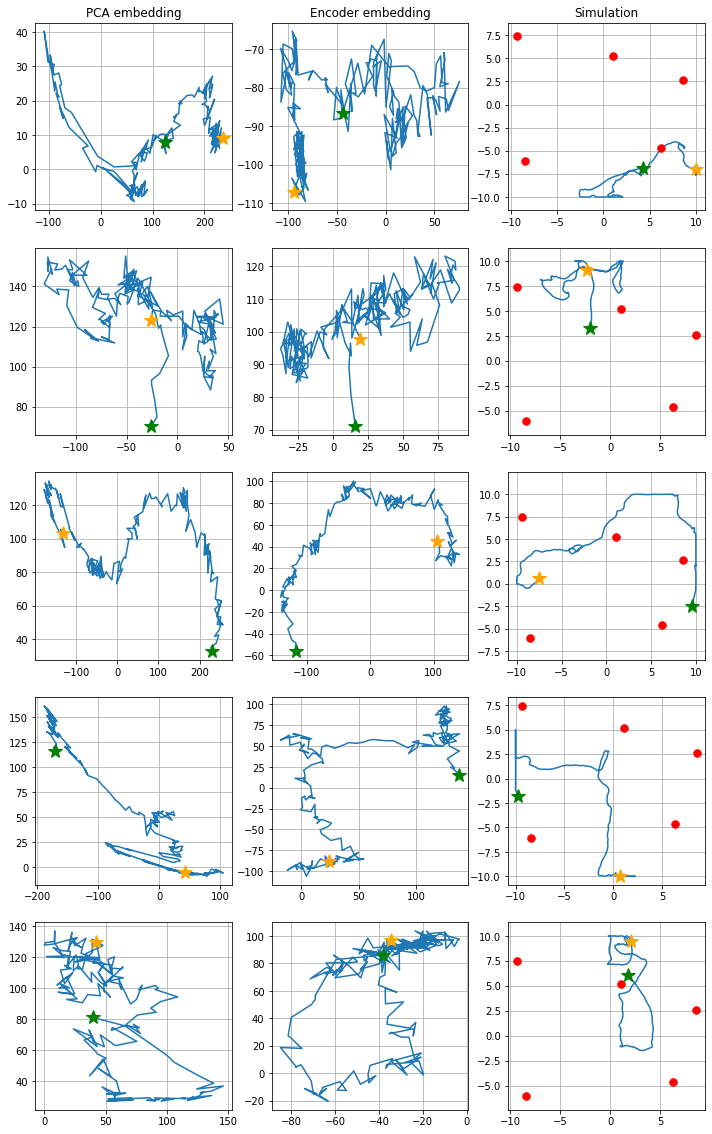

In [32]:
plot_embedding_pca(encoder, data, pca_2D_embedding.reshape((N_SIMULATIONS, N_STEPS, 2)), [0,1,2,3,4])

In [33]:
pca_recovery_loss = mse_loss(data[:][0].view(N_SIMULATIONS * N_STEPS, 3 * N_ANCHORS), torch.FloatTensor(pca.inverse_transform(pca_2D_embedding)))
pca_recovery_loss

tensor(139.9747)

## Adding constraints

Add constraints as losses

In [9]:
def recovery_loss(input, target, encoded, decoded):
    return mse_loss(decoded, input)

N_FIXED_POINTS = 3
def fixed_points_loss(input, target, encoded, decoded):
    mask = [0, encoded.size(0) // 2, -1]
    return mse_loss(encoded[mask], target[mask])

MAX_DISTANCE_THRESHOLD = 1
def subsequent_distances_loss(input, target, encoded, decoded):
    subsequent_distances = encoded[:-1].sub(encoded[1:]).pow(2).sum(dim=1)
    mask = subsequent_distances.gt(MAX_DISTANCE_THRESHOLD).float()
    return (subsequent_distances * mask).mean()

def angle_differences_loss(input, target, encoded, decoded):
    directions = encoded[1:].sub(encoded[:-1])
    angles = torch.atan2(directions[:, 1], directions[:, 0] + 1e-5)
    angle_differences = angles[:-1].sub(angles[1:])
    return angle_differences.pow(2).mean()

In [10]:
def train_encoder_with_constraints(model, train_loader, test_loader, nb_epochs, loss_functions):
    """Train a model with constraints"""
    
    optimizer = Adam(model.parameters())
    
    train_losses = {}
    test_losses = {}
    for loss_function in loss_functions:
        train_losses[loss_function['function'].__name__] = []
        test_losses[loss_function['function'].__name__] = []
    train_losses['total_loss'] = []
    test_losses['total_loss'] = []
    
    encoder, decoder = model

    for _ in range(nb_epochs):
        losses = {}
        for loss_function in loss_functions:
            losses[loss_function['function'].__name__] = []
        losses['total_loss'] = []
        
        for batch_input, batch_target in train_loader:
            input = batch_input.view(BATCH_SIZE * N_STEPS, 3 * N_ANCHORS)
            target = batch_target.view(BATCH_SIZE * N_STEPS, 2)
            encoded = encoder(input)
            decoded = decoder(encoded)
                
            loss = 0
            for loss_function in loss_functions:
                f_loss = loss_function['weight'] * loss_function['function'](input, target, encoded, decoded)
                loss = loss + f_loss
                losses[loss_function['function'].__name__].append(f_loss.item())
            losses['total_loss'].append(loss.item())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        for loss_function in loss_functions:
            train_losses[loss_function['function'].__name__].append(np.mean(losses[loss_function['function'].__name__]))
        train_losses['total_loss'].append(np.mean(losses['total_loss']))
            
        losses = {}
        for loss_function in loss_functions:
            losses[loss_function['function'].__name__] = []
        losses['total_loss'] = []
        
        for batch_input, batch_target in test_loader:
            input = batch_input.view(BATCH_SIZE * N_STEPS, 3 * N_ANCHORS)
            target = batch_target.view(BATCH_SIZE * N_STEPS, 2)
            encoded = encoder(input)
            decoded = decoder(encoded)
                
            loss = 0
            for loss_function in loss_functions:
                f_loss = loss_function['weight'] * loss_function['function'](input, target, encoded, decoded)
                loss = loss + f_loss
                losses[loss_function['function'].__name__].append(f_loss.item())
            losses['total_loss'].append(loss.item())
            
        for loss_function in loss_functions:
            test_losses[loss_function['function'].__name__].append(np.mean(losses[loss_function['function'].__name__]))
        test_losses['total_loss'].append(np.mean(losses['total_loss']))
        
    return train_losses, test_losses

In [11]:
def plot_multiloss_evolution(train_losses, test_losses, ylim=[0,200]):
    assert len(train_losses) == len(test_losses) and len(train_losses) <= 6
    colors = sns.color_palette('Paired')
    loss_names = []
    
    plt.figure(figsize=(12,6))
    for idx, loss_name in enumerate(train_losses):
        plt.plot(train_losses[loss_name], c=colors[2 * idx])
        plt.plot(test_losses[loss_name], c=colors[2 * idx + 1])
        loss_names.append('train_' + loss_name)
        loss_names.append('test_' + loss_name)
    
    plt.legend(loss_names)
    plt.ylim(ylim)
    plt.grid(True);

#### With subsequent distance constraint

In [37]:
%%time

model_with_distance = create_autoencoder_model(dim=2)
loss_functions = [
    {
        'function': recovery_loss,
        'weight': 1.0
    }, {
        'function': subsequent_distances_loss,
        'weight': 10.0
    }
]

train_losses_with_distance, test_losses_with_distance = train_encoder_with_constraints(model_with_distance, train_loader, test_loader, 10 * N_EPOCHS, loss_functions)
result_with_distance = {
    'model': model_with_distance,
    'train_loss': train_losses_with_distance,
    'test_loss': test_losses_with_distance
}

CPU times: user 14min 41s, sys: 6.98 s, total: 14min 48s
Wall time: 14min 46s


In [38]:
# Save result
result_name = 'autoencoder_with_distance'
save_result(result_with_distance, result_name)

In [58]:
# Load result
result_name = 'autoencoder_with_distance'
result_with_distance = load_result(result_name, create_autoencoder_model(2))

Text(0.5, 1.0, '2D embedding with successive distance loss')

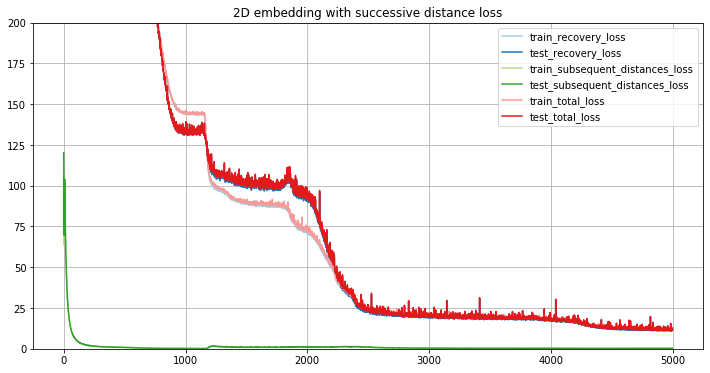

In [60]:

plot_multiloss_evolution(result_with_distance['train_loss'], result_with_distance['test_loss'])
plt.title('2D embedding with successive distance loss')

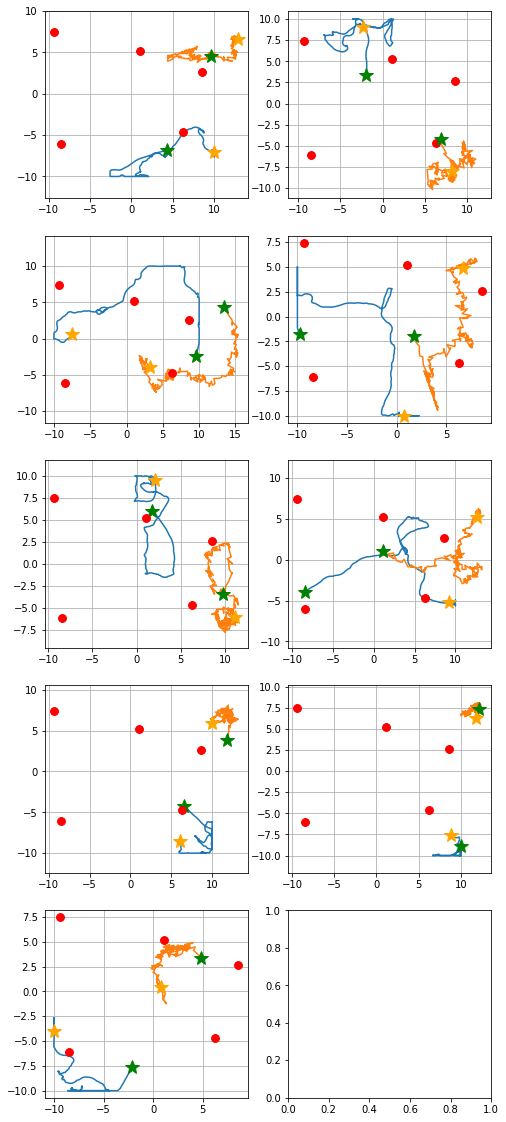

In [62]:
plot_embedding_on_simulation(result_with_distance['model'][0], data, range(9))

#### With fixed points

In [20]:
%%time

model_with_fixed_points = create_autoencoder_model(dim=2)
loss_functions = [
    {
        'function': recovery_loss,
        'weight': 1.0
    }, {
        'function': fixed_points_loss,
        'weight': 1.0
    }
]

train_losses_with_fixed_points, test_losses_with_fixed_points = train_encoder_with_constraints(model_with_fixed_points, train_loader, test_loader, 10 * N_EPOCHS, loss_functions)
result_with_fixed_points = {
    'model': model_with_fixed_points,
    'train_loss': train_losses_with_fixed_points,
    'test_loss': test_losses_with_fixed_points
}

KeyboardInterrupt: 

In [43]:
# Save result
result_name = 'autoencoder_with_fixed_points'
save_result(result_with_fixed_points, result_name)

In [63]:
# Load result
result_name = 'autoencoder_with_fixed_points'
result_with_fixed_points = load_result(result_name, create_autoencoder_model(2))

Text(0.5, 1.0, '2D embedding with fixed points loss')

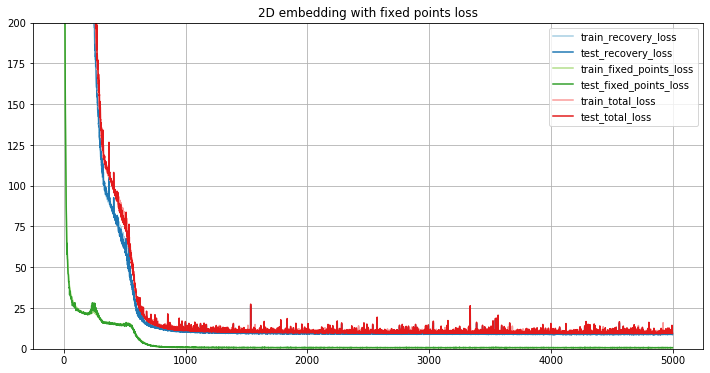

In [66]:
plot_multiloss_evolution(result_with_fixed_points['train_loss'], result_with_fixed_points['test_loss'])
plt.title('2D embedding with fixed points loss')

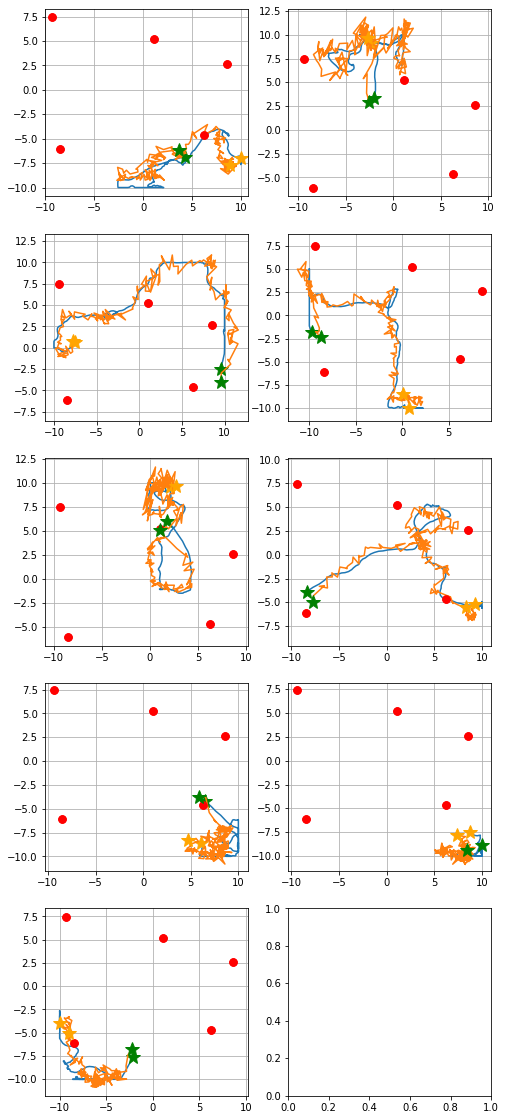

In [65]:
plot_embedding_on_simulation(result_with_fixed_points['model'][0], data, range(9))

#### With angles

In [47]:
%%time

model_with_angles = create_autoencoder_model(dim=2)
loss_functions = [
    {
        'function': recovery_loss,
        'weight': 1.0
    }, {
        'function': fixed_points_loss,
        'weight': 1.0
    }, {
        'function': angle_differences_loss,
        'weight': 10
    }
]

train_losses_with_angles, test_losses_with_angles = train_encoder_with_constraints(model_with_angles, train_loader, test_loader, 10 * N_EPOCHS, loss_functions)
result_with_angles = {
    'model': model_with_angles,
    'train_loss': train_losses_with_angles,
    'test_loss': test_losses_with_angles
}

CPU times: user 17min 30s, sys: 8.09 s, total: 17min 38s
Wall time: 17min 36s


In [48]:
# Save result
result_name = 'autoencoder_with_angles'
save_result(result_with_angles, result_name)

In [49]:
# Load result
result_name = 'autoencoder_with_angles'
result_with_angles = load_result(result_name, create_autoencoder_model(2))

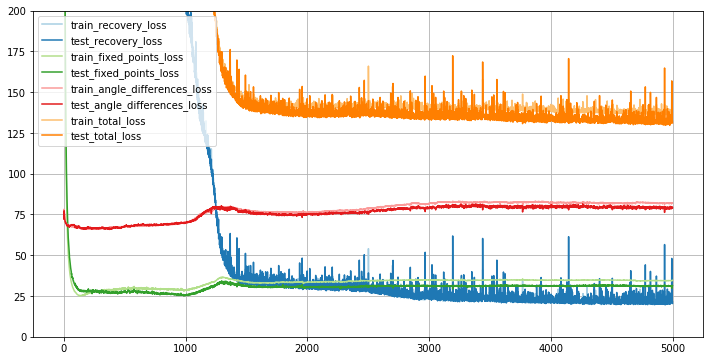

In [50]:
plot_multiloss_evolution(result_with_angles['train_loss'], result_with_angles['test_loss'])

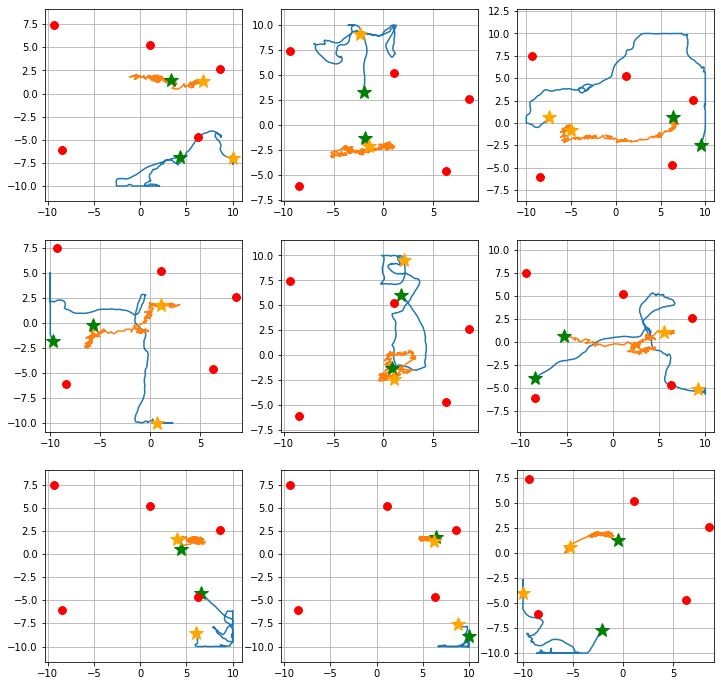

In [51]:
plot_embedding_on_simulation(result_with_angles['model'][0], data, range(9))

#### With all constraints

In [52]:
%%time

model_with_constraints = create_autoencoder_model(dim=2)
loss_functions = [
    {
        'function': recovery_loss,
        'weight': 1.0
    }, {
        'function': fixed_points_loss,
        'weight': 1.0
    }, {
        'function': subsequent_distances_loss,
        'weight': 10.0
    }
]

train_losses_with_constraints, test_losses_with_constraints = train_encoder_with_constraints(model_with_constraints, train_loader, test_loader, 10 * N_EPOCHS, loss_functions)
result_with_constraints = {
    'model': model_with_constraints,
    'train_loss': train_losses_with_constraints,
    'test_loss': test_losses_with_constraints
}

CPU times: user 15min 52s, sys: 7.57 s, total: 16min
Wall time: 15min 58s


In [56]:
# Save result
result_name = 'autoencoder_with_constraints'
save_result(result_with_constraints, result_name)

In [69]:
# Load result
result_name = 'autoencoder_with_constraints'
result_with_constraints = load_result(result_name, create_autoencoder_model(2))

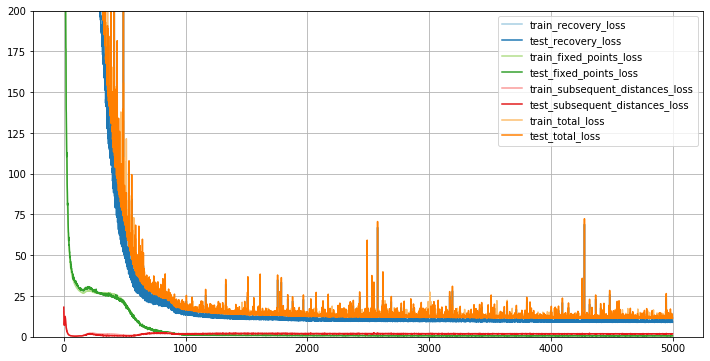

In [58]:
plot_multiloss_evolution(result_with_constraints['train_loss'], result_with_constraints['test_loss'])

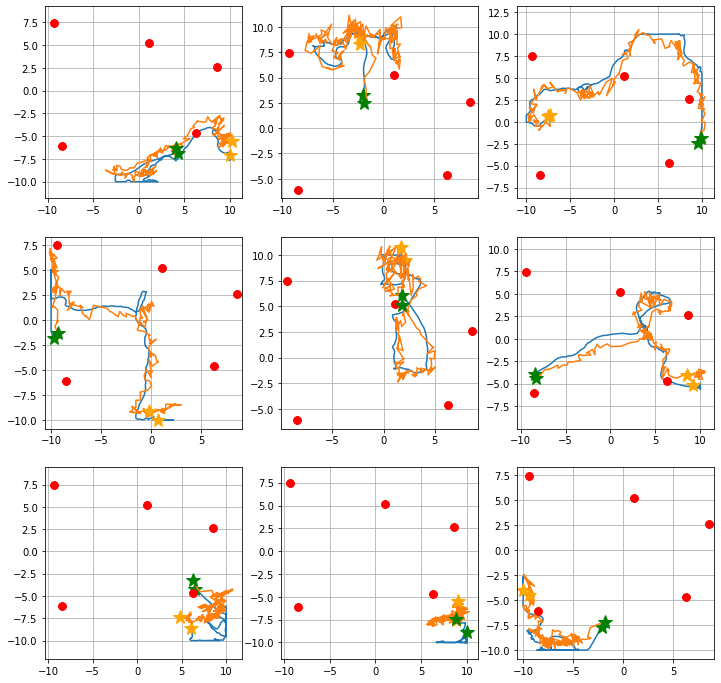

In [59]:
plot_embedding_on_simulation(result_with_constraints['model'][0], data, range(9))

## Run mutiple experiments

In [70]:
n_experiments = 5

anchors_pos_e1 = torch.FloatTensor([
    [-10, -10],
    [-10, 10],
    [10, -10],
    [10, 10],
    [0, 0]
]) + torch.empty(5,2).normal_()

anchors_pos_e2 = torch.FloatTensor([
    [-5, -5],
    [-5, 5],
    [5, -5],
    [5, 5],
    [0, 0]
]) + torch.empty(5,2).normal_()

anchors_pos_e3 = torch.FloatTensor([
    [-10, -10],
    [10, 10],
    [-3, 3],
    [3, -3],
    [0, 0]
]) + torch.empty(5,2).normal_()

anchors_pos_e4 = torch.FloatTensor([
    [-10, -10],
    [-10, 0],
    [0, 0],
    [10, 0],
    [10, 10]
]) + torch.empty(5,2).normal_()

anchors_pos_e5 = torch.FloatTensor([
    [-10, -10],
    [-10, 0],
    [-10, 10],
    [0, 10],
    [10, 10]
]) + torch.empty(5,2).normal_()

anchors_pos_es = [anchors_pos_e1, anchors_pos_e2, anchors_pos_e3, anchors_pos_e4, anchors_pos_e5]

In [93]:
# Save anchor positions
for idx in range(n_experiments):
    anchors_file_name_e = join(DATA_PATH, f'anchors_pos_e{idx}.pt')
    torch.save(anchors_pos_es[idx], anchors_file_name_e)

In [71]:
# Load anchor positions
anchors_pos_es = []
for idx in range(n_experiments):
    anchors_file_name_e = join(DATA_PATH, f'anchors_pos_e{idx}.pt')
    anchors_pos_e = torch.load(anchors_file_name_e)
    anchors_pos_es.append(anchors_pos_e)

In [94]:
%%time

# experiments = [
#     ...
#     }, {
#         'data': data,
#         'model': model,
#         'train_losses': train_losses,
#         'test_losses': test_losses
#     }, {
#     ...
# ]
experiments = []

for experiment_idx in range(n_experiments):
    data_e = SimulationData(simulations, anchors_pos_es[experiment_idx])
    train_loader_e, test_loader_e = data_e.get_random_loaders(0.8, BATCH_SIZE)
    model_e = create_autoencoder_model(2)
    loss_functions = [
        {
            'function': recovery_loss,
            'weight': 1.0
        }, {
            'function': fixed_points_loss,
            'weight': 1.0
        }, {
            'function': subsequent_distances_loss,
            'weight': 10.0
        }
    ]
    train_losses_e, test_losses_e = train_encoder_with_constraints(model_e, train_loader_e, test_loader_e, 40 * N_EPOCHS, loss_functions)
    experiments.append({
        'data': data_e,
        'model': model_e,
        'train_loss': train_losses_e,
        'test_loss': test_losses_e
    })

CPU times: user 5h 18min 33s, sys: 2min 28s, total: 5h 21min 1s
Wall time: 5h 20min 21s


In [89]:
# Save experiments
for idx, experiment in enumerate(experiments):
    result_name = f'autoencoder_with_constraints_e{idx}'
    save_result({
        'model': experiment['model'],
        'train_loss': experiment['train_loss'],
        'test_loss': experiment['test_loss']
    }, result_name)

In [72]:
# Load experiments
experiments = []
for idx in range(n_experiments):
    result_name = f'autoencoder_with_constraints_e{idx}'
    result = load_result(result_name, create_autoencoder_model(2))
    
    experiment = {}
    experiment['model'] = result['model']
    experiment['train_loss'] = result['train_loss']
    experiment['test_loss'] = result['test_loss']
    experiment['data'] = SimulationData(simulations, anchors_pos_es[idx])
    experiments.append(experiment)

########## EXPERIMENT 1 ##########


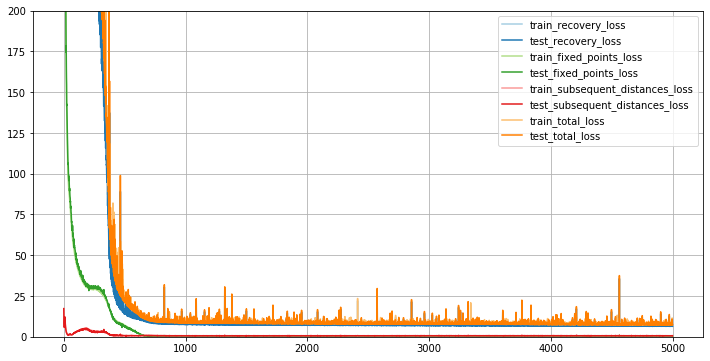

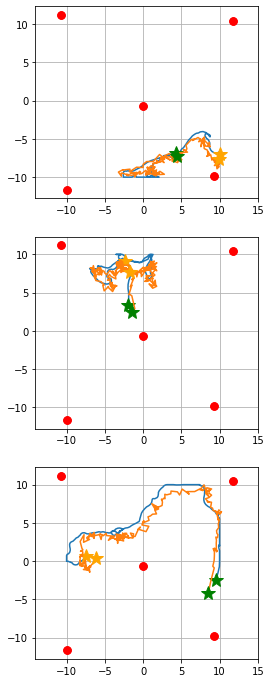

########## EXPERIMENT 2 ##########


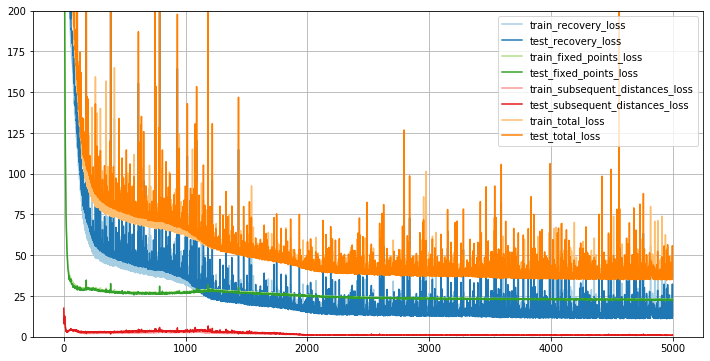

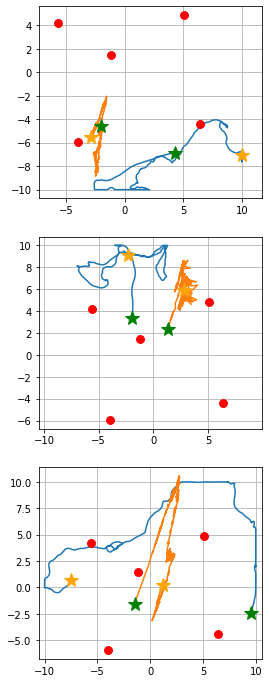

########## EXPERIMENT 3 ##########


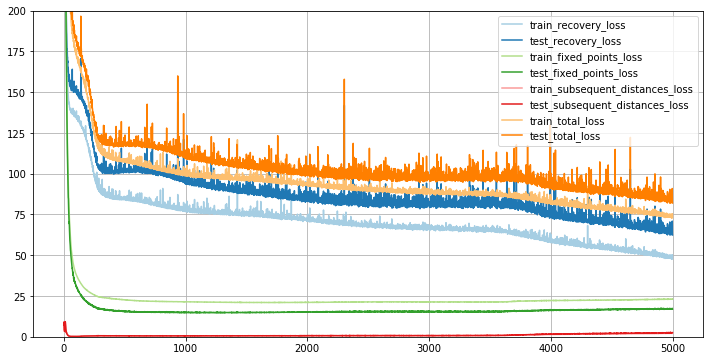

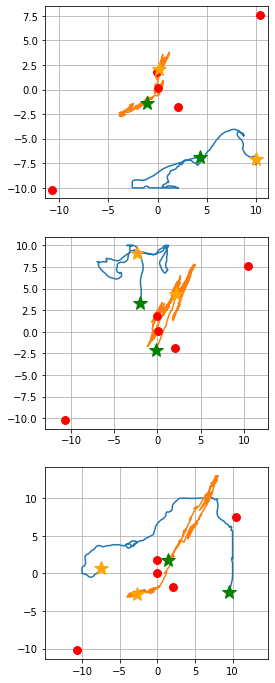

########## EXPERIMENT 4 ##########


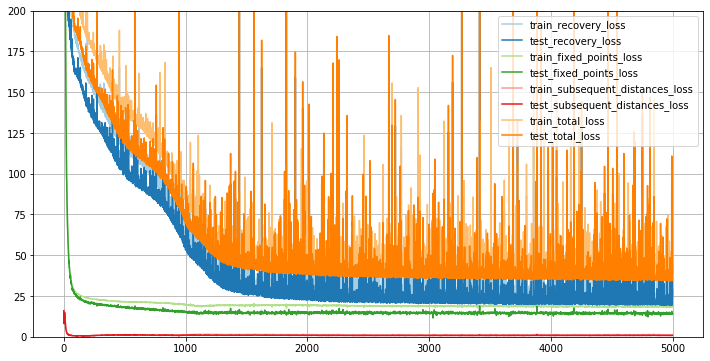

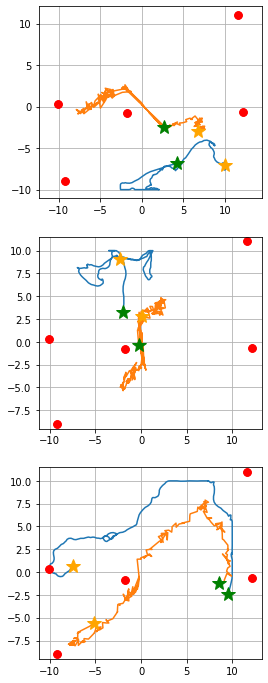

########## EXPERIMENT 5 ##########


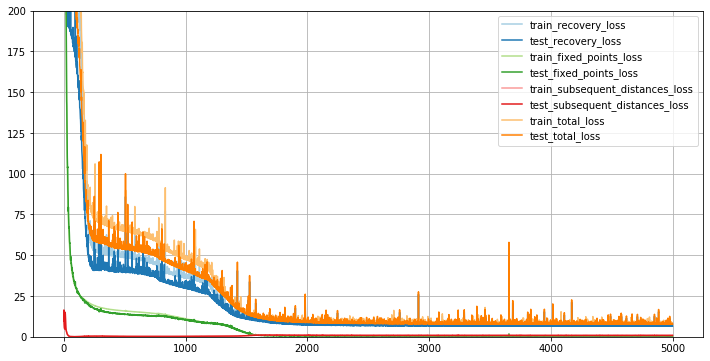

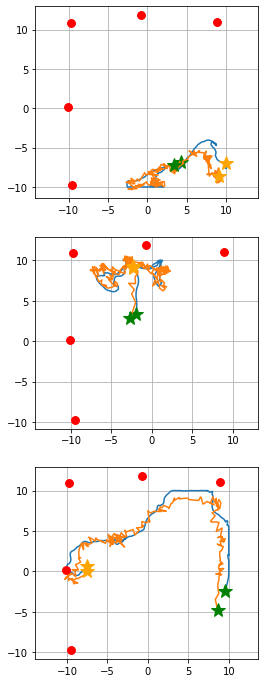

In [81]:
for idx, experiment in enumerate(experiments):
    print(f'########## EXPERIMENT {idx + 1} ##########')
    plot_multiloss_evolution(experiment['train_loss'], experiment['test_loss'])
    plt.show()
    plot_embedding_on_simulation(experiment['model'][0], experiment['data'], range(3))
    plt.show()
    

## Weighted recovery loss

In [16]:
rssi_mean_indices = torch.arange(N_ANCHORS)
rssi_std_indices = N_ANCHORS + rssi_mean_indices
rtt_indices = N_ANCHORS + rssi_std_indices

print('rssi_mean_indices:', rssi_mean_indices.numpy())
print('rssi_std_indices:', rssi_std_indices.numpy())
print('rtt_indices:', rtt_indices.numpy())

rssi_mean_indices: [0 1 2 3 4]
rssi_std_indices: [5 6 7 8 9]
rtt_indices: [10 11 12 13 14]


In [17]:
def rssi_mean_recovery_loss(input, target, encoded, decoded):
    return mse_loss(decoded[..., rssi_mean_indices], input[..., rssi_mean_indices])

In [18]:
def rssi_std_recovery_loss(input, target, encoded, decoded):
    return mse_loss(decoded[..., rssi_std_indices], input[..., rssi_std_indices])

In [19]:
def rtt_recovery_loss(input, target, encoded, decoded):
    return mse_loss(decoded[..., rtt_indices], input[..., rtt_indices])

In [20]:
%%time

model_with_split_recovery_loss = create_autoencoder_model(dim=2)
loss_functions = [
    {
        'function': rssi_mean_recovery_loss,
        'weight': 1.0
    }, {
        'function': rssi_std_recovery_loss,
        'weight': 1.0
    }, {
        'function': rtt_recovery_loss,
        'weight': 1.0
    }
]

train_losses_with_split_recovery_loss, test_losses_with_split_recovery_loss = train_encoder_with_constraints(model_with_split_recovery_loss, train_loader, test_loader, 5 * N_EPOCHS, loss_functions)
result_with_split_recovery_loss = {
    'model': model_with_split_recovery_loss,
    'train_loss': train_losses_with_split_recovery_loss,
    'test_loss': test_losses_with_split_recovery_loss
}

CPU times: user 14min 10s, sys: 7.85 s, total: 14min 18s
Wall time: 14min 22s


In [21]:
# Save result
result_name = 'autoencoder_with_split_recovery_loss'
save_result(result_with_split_recovery_loss, result_name)

In [22]:
# Load result
result_name = 'autoencoder_with_split_recovery_loss'
result_with_split_recovery_loss = load_result(result_name, create_autoencoder_model(2))

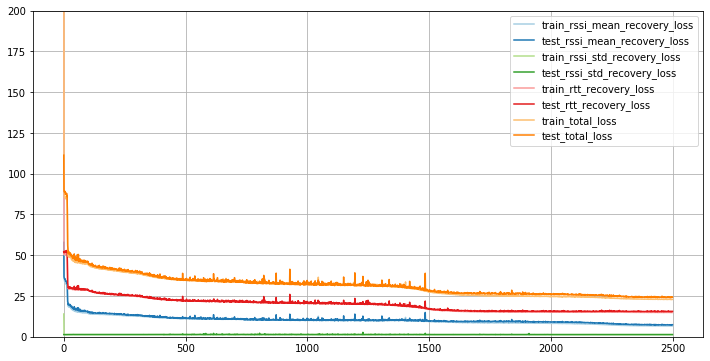

In [23]:
plot_multiloss_evolution(result_with_split_recovery_loss['train_loss'], result_with_split_recovery_loss['test_loss'])

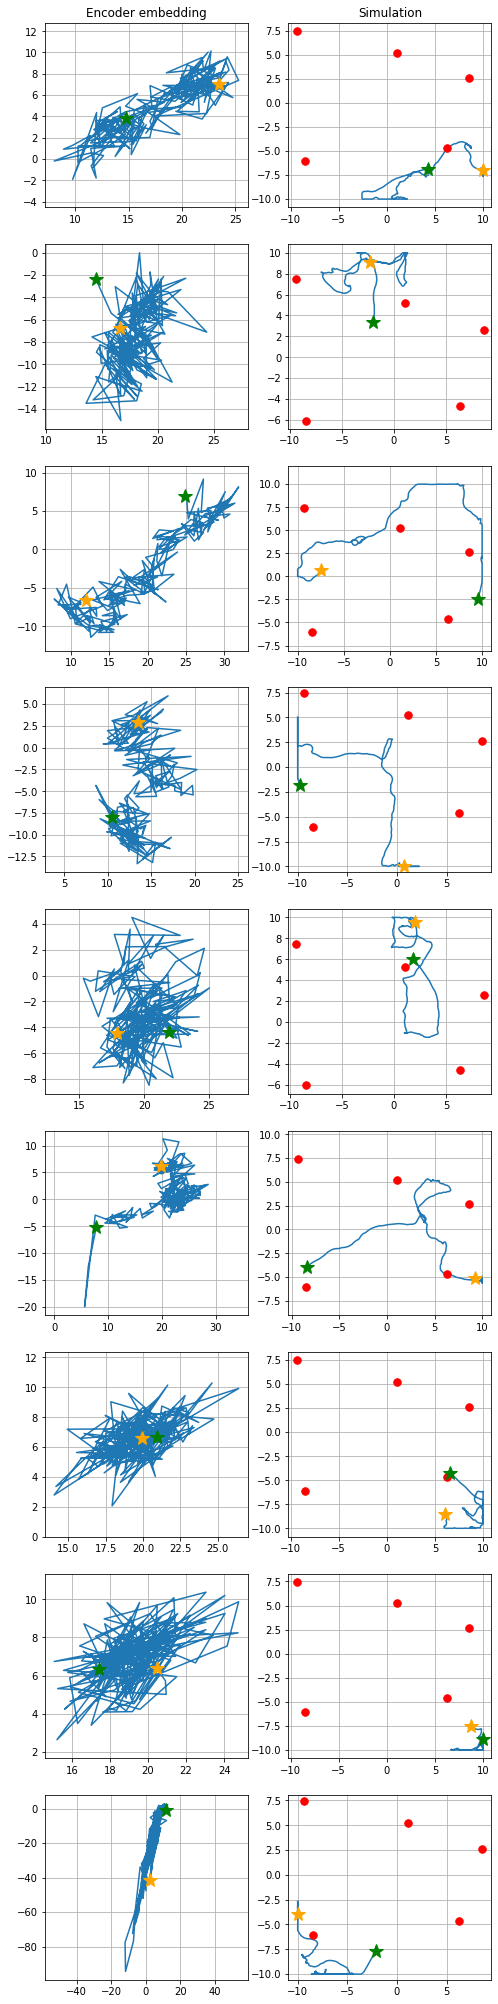

In [25]:
plot_embedding(result_with_split_recovery_loss['model'][0] , data, range(9))

In [26]:
data_stds = data[:][0].std((0,1))
data_stds

tensor([5.2381, 6.0939, 5.1517, 5.3593, 6.4452, 1.1613, 1.1599, 1.1690, 1.1645,
        1.1528, 7.4657, 7.3365, 6.3463, 6.6402, 8.0516])

In [30]:
out = result_with_split_recovery_loss['model'](data[:][0])
data[:][0].sub(out).pow(2).std((0,1))

tensor([ 9.2571,  9.7168, 18.6612, 29.8357,  7.9770,  1.9485,  1.9192,  1.9626,
         1.9276,  1.8701, 18.4280, 19.3079, 19.2446, 27.7441, 22.3961],
       grad_fn=<StdBackward1>)

In [31]:
rssi_mean_stds = data_stds[rssi_mean_indices]
rssi_std_stds = data_stds[rssi_std_indices]
rtt_stds = data_stds[rtt_indices]

In [32]:
def rescaled_rssi_mean_recovery_loss(input, target, encoded, decoded):
    return decoded[..., rssi_mean_indices].sub(input[..., rssi_mean_indices]).pow(2).div(rssi_mean_stds).mean()

In [33]:
def rescaled_rssi_std_recovery_loss(input, target, encoded, decoded):
    return decoded[..., rssi_std_indices].sub(input[..., rssi_std_indices]).pow(2).div(rssi_std_stds).mean()

In [34]:
def rescaled_rtt_recovery_loss(input, target, encoded, decoded):
    return decoded[..., rtt_indices].sub(input[..., rtt_indices]).pow(2).div(rtt_stds).mean()

In [39]:
%%time

model_with_rescaled_recovery_loss = create_autoencoder_model(dim=2)
loss_functions = [
    {
        'function': rescaled_rssi_mean_recovery_loss,
        'weight': 1.0
    }, {
        'function': rescaled_rssi_std_recovery_loss,
        'weight': 1.0
    }, {
        'function': rescaled_rtt_recovery_loss,
        'weight': 1.0
    }
]

train_losses_with_rescaled_recovery_loss, test_losses_with_rescaled_recovery_loss = train_encoder_with_constraints(model_with_rescaled_recovery_loss, train_loader, test_loader, 5 * N_EPOCHS, loss_functions)
result_with_rescaled_recovery_loss = {
    'model': model_with_rescaled_recovery_loss,
    'train_loss': train_losses_with_rescaled_recovery_loss,
    'test_loss': test_losses_with_rescaled_recovery_loss
}

CPU times: user 16min, sys: 8.48 s, total: 16min 8s
Wall time: 16min 12s


In [41]:
# Save result
result_name = 'autoencoder_with_rescaled_recovery_loss'
save_result(result_with_rescaled_recovery_loss, result_name)

In [42]:
# Load result
result_name = 'autoencoder_with_rescaled_recovery_loss'
result_with_rescaled_recovery_loss = load_result(result_name, create_autoencoder_model(2))

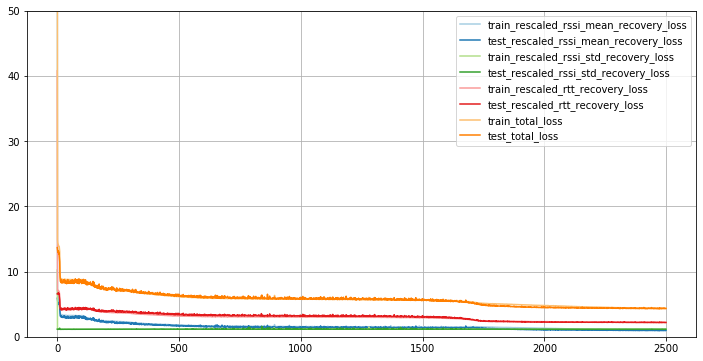

In [43]:
plot_multiloss_evolution(result_with_rescaled_recovery_loss['train_loss'], result_with_rescaled_recovery_loss['test_loss'], ylim=[0,50])

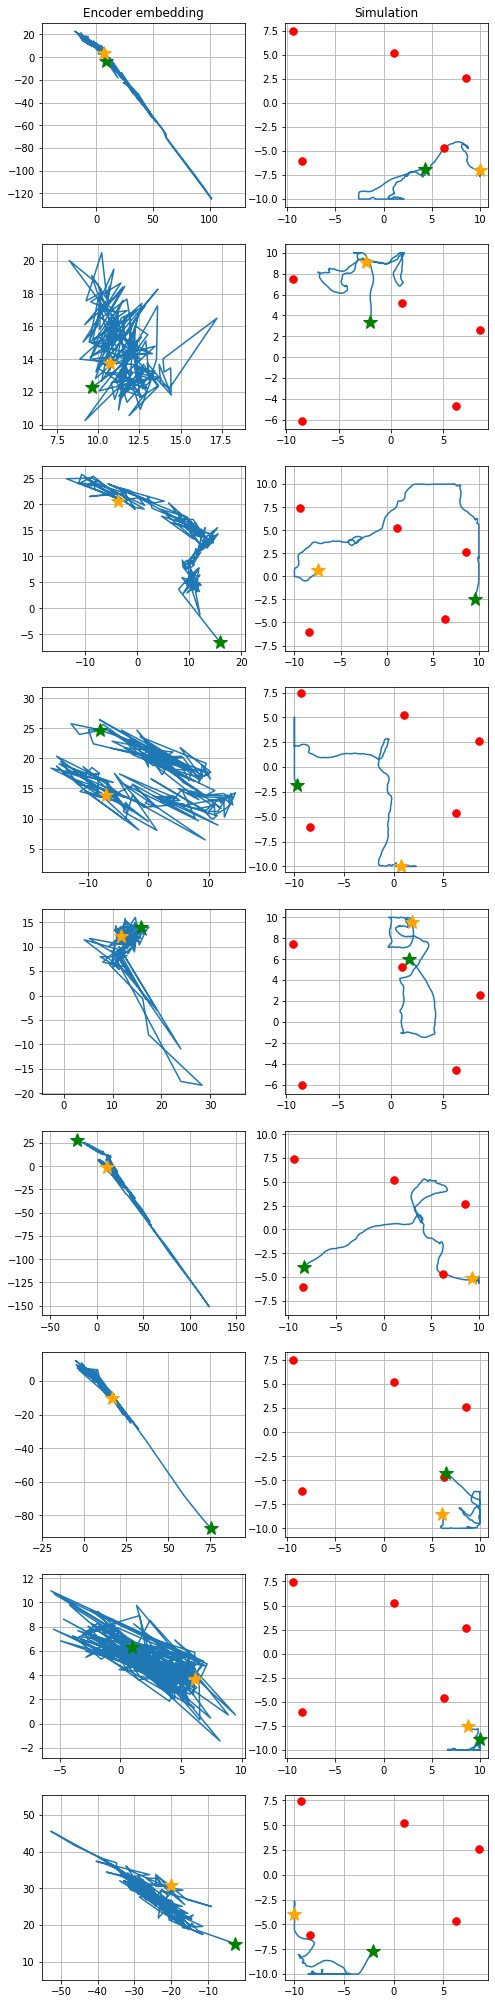

In [45]:
plot_embedding(result_with_rescaled_recovery_loss['model'][0] , data, range(9))

In [46]:
%%time

model_with_rescaled_and_reweighted_recovery_loss = create_autoencoder_model(dim=2)
loss_functions = [
    {
        'function': rescaled_rssi_mean_recovery_loss,
        'weight': 1.0
    }, {
        'function': rescaled_rssi_std_recovery_loss,
        'weight': 0.5
    }, {
        'function': rescaled_rtt_recovery_loss,
        'weight': 10.0
    }
]

train_losses_with_rescaled_and_reweighted_recovery_loss, test_losses_with_rescaled_and_reweighted_recovery_loss = train_encoder_with_constraints(model_with_rescaled_and_reweighted_recovery_loss, train_loader, test_loader, 5 * N_EPOCHS, loss_functions)
result_with_rescaled_and_reweighted_recovery_loss = {
    'model': model_with_rescaled_and_reweighted_recovery_loss,
    'train_loss': train_losses_with_rescaled_and_reweighted_recovery_loss,
    'test_loss': test_losses_with_rescaled_and_reweighted_recovery_loss
}

CPU times: user 16min 46s, sys: 7.71 s, total: 16min 54s
Wall time: 16min 58s


In [47]:
# Save result
result_name = 'autoencoder_with_rescaled_and_reweighted_recovery_loss'
save_result(result_with_rescaled_and_reweighted_recovery_loss, result_name)

In [48]:
# Load result
result_name = 'autoencoder_with_rescaled_and_reweighted_recovery_loss'
result_with_rescaled_and_reweighted_recovery_loss = load_result(result_name, create_autoencoder_model(2))

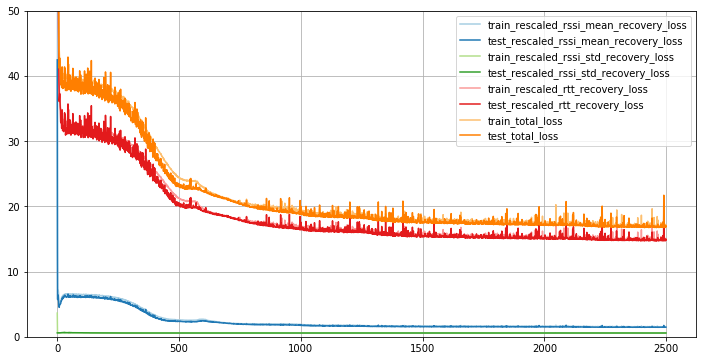

In [49]:
plot_multiloss_evolution(result_with_rescaled_and_reweighted_recovery_loss['train_loss'], result_with_rescaled_and_reweighted_recovery_loss['test_loss'], ylim=[0,50])

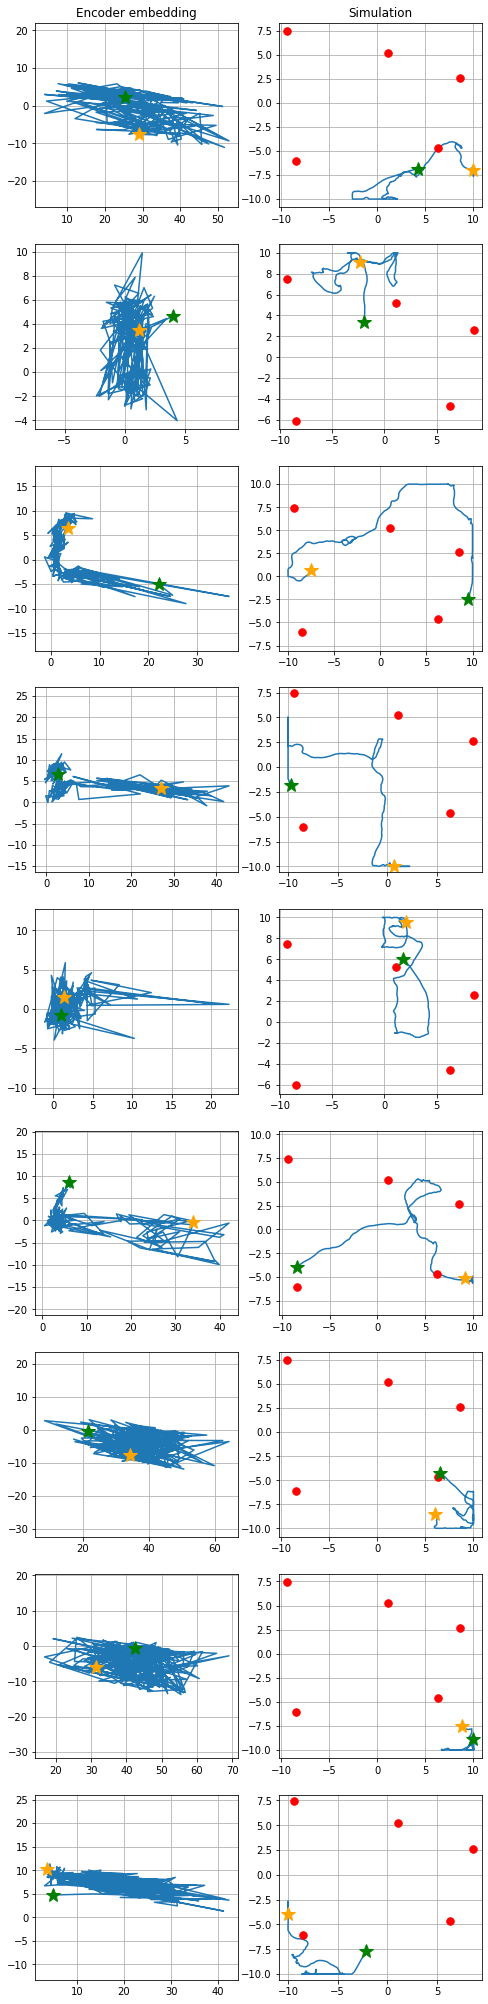

In [50]:
plot_embedding(result_with_rescaled_and_reweighted_recovery_loss['model'][0] , data, range(9))

In [52]:
%%time

model_with_rescaled_and_reweighted_recovery_loss = create_autoencoder_model(dim=2)
loss_functions = [
    {
        'function': rescaled_rssi_mean_recovery_loss,
        'weight': 1.0
    }, {
        'function': rescaled_rssi_std_recovery_loss,
        'weight': 1.0
    }, {
        'function': rescaled_rtt_recovery_loss,
        'weight': 10.0
    }
]

train_losses_with_rescaled_and_reweighted_recovery_loss, test_losses_with_rescaled_and_reweighted_recovery_loss = train_encoder_with_constraints(model_with_rescaled_and_reweighted_recovery_loss, train_loader, test_loader, 10 * N_EPOCHS, loss_functions)
result_with_rescaled_and_reweighted_recovery_loss = {
    'model': model_with_rescaled_and_reweighted_recovery_loss,
    'train_loss': train_losses_with_rescaled_and_reweighted_recovery_loss,
    'test_loss': test_losses_with_rescaled_and_reweighted_recovery_loss
}

CPU times: user 36min 23s, sys: 17.3 s, total: 36min 40s
Wall time: 37min 15s


In [47]:
# Save result
result_name = 'autoencoder_with_rescaled_and_reweighted_recovery_loss'
save_result(result_with_rescaled_and_reweighted_recovery_loss, result_name)

In [48]:
# Load result
result_name = 'autoencoder_with_rescaled_and_reweighted_recovery_loss'
result_with_rescaled_and_reweighted_recovery_loss = load_result(result_name, create_autoencoder_model(2))

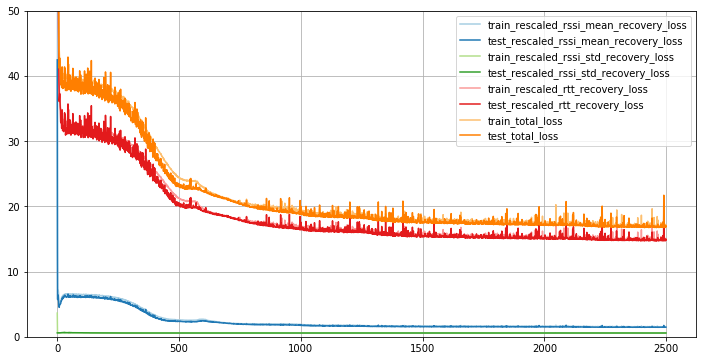

In [49]:
plot_multiloss_evolution(result_with_rescaled_and_reweighted_recovery_loss['train_loss'], result_with_rescaled_and_reweighted_recovery_loss['test_loss'], ylim=[0,50])

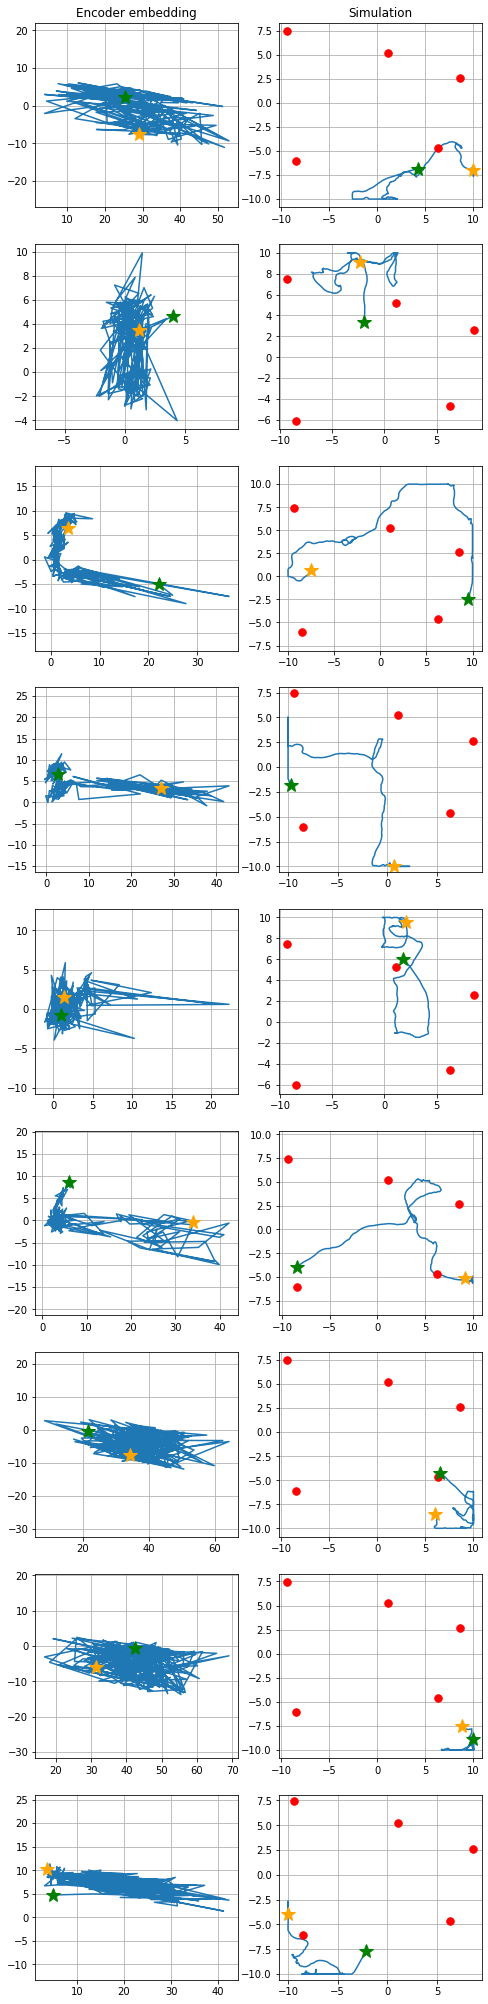

In [50]:
plot_embedding(result_with_rescaled_and_reweighted_recovery_loss['model'][0] , data, range(9))

## RNN based autoencoder

In [157]:
class RNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        
        self.nn_out = nn.Linear(input_dim + hidden_dim, hidden_dim)
        
    def forward(self, x):
        batch_size = x.size(1)
        hidden = torch.zeros(batch_size, self.hidden_dim)
        output = torch.zeros(x.size(0), batch_size, self.hidden_dim)

        for i in range(x.size(0)):
            input_ = torch.cat((x[i], hidden), dim=-1)
            hidden = self.nn_out(input_)
            output[i] = hidden
            
        return output

In [158]:
encoder_rnn = nn.Sequential(
    RNN(3 * N_ANCHORS, 12), nn.ReLU(),
    nn.Linear(12, 2)
)

decoder_rnn = nn.Sequential(
    nn.Linear(2, 12), nn.ReLU(),
    RNN(12, 3 * N_ANCHORS)
)

model_rnn = nn.Sequential(encoder_rnn, decoder_rnn)

In [159]:
BATCH_SIZE = 200
train_loader_rnn, test_loader_rnn = data.get_random_loaders(0.8, BATCH_SIZE)

In [163]:
def train_encoder_rnn(model, train_loader, test_loader, nb_epochs, loss_function=nn.MSELoss()):
    """Train a model"""
    
    optimizer = Adam(model.parameters())
    train_losses = []
    test_losses = []
    
    encoder, decoder = model

    for e in range(nb_epochs):
        print(e)
        losses = []
        for batch_input, batch_target in train_loader:
            input = batch_input.transpose(0,1)
            target = batch_target.transpose(0,1)
            encoded = encoder(input)
            decoded = decoder(encoded)
            
            loss = loss_function(decoded, input)
            
            optimizer.zero_grad() # set gradients to zero
            loss.backward() # compute gradient
            optimizer.step() # update weights
            losses.append(loss.item())
        train_losses.append(torch.Tensor(losses).mean().item())
            
        losses = []
        for batch_input, batch_target in test_loader:
            input = batch_input.transpose(0,1)
            target = batch_target.transpose(0,1)
            encoded = encoder(input)
            decoded = decoder(encoded)
            
            loss = loss_function(decoded, input)
            losses.append(loss.item())
        test_losses.append(torch.Tensor(losses).mean().item())
        
    return train_losses, test_losses

In [164]:
%%time

train_losses_rnn, test_losses_rnn = train_encoder_rnn(model_rnn, train_loader, test_loader, 100)
result_rnn = {
    'model': model_rnn,
    'train_loss': train_losses_rnn,
    'test_loss': test_losses_rnn
}

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
CPU times: user 2min 3s, sys: 68 ms, total: 2min 3s
Wall time: 2min 3s


In [22]:
# Save result
result_name = 'autoencoder_2D_embedding_long'
save_result(result_2D, result_name)

In [16]:
# Load result
result_name = 'autoencoder_2D_embedding_long'
result_2D = load_result(result_name, create_autoencoder_model(2))

---

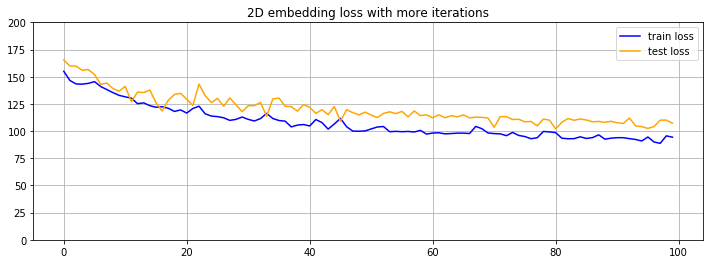

In [165]:
plt.figure(figsize=(12,4))
plt.title('2D embedding loss with more iterations')
plot_loss_evolution(result_rnn['train_loss'], result_rnn['test_loss'])